In [1]:
import numpy as np
import re
import math
import random
import matplotlib.pyplot as plt

In [22]:
def import_data(fileName):
    data = []
    with open(fileName) as f:
        for line in f:
            cords = re.split('\s+', line)
            data.append([float(cords[0]),float(cords[1])])
    return data

# Specify filename
#fileName = "file-tsp.txt"
fileName = "att532.tsp"
data = import_data(fileName)

In [23]:
def dist(city1, city2):
    return math.sqrt((city1[0] - city2[0])**2 + (city1[1] - city1[1]))

In [24]:
distance_matrix = np.zeros((len(data),len(data)))

for i, city1 in enumerate(data):
    for j, city2 in enumerate(data):
        distance_matrix[i,j] = dist(city1, city2)


In [25]:
print(distance_matrix)

[[   0.   12.  546. ... 6307. 2417. 2341.]
 [  12.    0.  534. ... 6295. 2405. 2329.]
 [ 546.  534.    0. ... 5761. 1871. 1795.]
 ...
 [6307. 6295. 5761. ...    0. 3890. 3966.]
 [2417. 2405. 1871. ... 3890.    0.   76.]
 [2341. 2329. 1795. ... 3966.   76.    0.]]


In [26]:
def fitness(sequence):
    total_distance = 0
    for i in range(1,len(sequence)):
        total_distance += distance_matrix[sequence[i], sequence[i-1]]

    # In the slides 1/total_distance is used, this often gives a very small floating number
    return total_distance

def tsp_crossover(parent1, parent2):
    cutoff = sorted(random.sample(range(1,len(parent1)), 2))

    middle_p1 = parent1[cutoff[0]:cutoff[1]]
    middle_p2 = parent2[cutoff[0]:cutoff[1]]

    complement_p1 = parent1.copy()
    complement_p2 = parent2.copy()

    for x in middle_p1:
        complement_p2.remove(x)

    for x in middle_p2:
        complement_p1.remove(x)
    
    cutoff_complement = len(parent1) - cutoff[0]

    child1 = complement_p2[cutoff_complement:] + middle_p1 + complement_p2[:cutoff_complement] 
    child2 = complement_p1[cutoff_complement:] + middle_p2 + complement_p1[:cutoff_complement]

    return child1, child2

def tsp_mutation(parent):
    i1, i2 = random.sample(range(len(parent)), 2)
    parent[i1], parent[i2] = parent[i2], parent[i1]
    return parent

def swap_2opt(parent, i1, i2):
    middle = parent[i1:i2+1]
    middle.reverse()
    return parent[:i1] + middle + parent[i2+1:]

def determine_new_route(route):
    best_distance = fitness(route)

    for i in range(0,len(route)-1):
        for j in range(1, len(route)):
            new_route = swap_2opt(route, i, j)
            new_distance = fitness(new_route)

            if new_distance < best_distance:
                return new_route, new_distance
    
    return None, best_distance


In [34]:
N = 50
K = 2
mutation_rate = 0.01
generations = 1500

def TSP():
    # Create population
    population = []
    distances = []
    for _ in range(N):
        population.append(np.random.permutation(len(data)).tolist())

    for _ in range(generations):
        # Tournament selection
        parents = []
        indexes = np.random.permutation(len(population))
        for x, y in zip(*[iter(indexes)]*2):
            fitness_x = fitness(population[x])
            fitness_y = fitness(population[y])
            parents.append(x) if fitness_x < fitness_y else parents.append(y)
        
        # Roll the parents over by 1 such that we get pairs of parents
        parents_1 = np.roll(np.array(parents), 1)

        new_population = []
        min_distance = 100000000

        # Perform the crossover and select the top 2 routes
        for i in range(len(parents)):
            parent_1 = population[parents[i]]
            parent_2 = population[parents_1[i]]

            child1, child2 = tsp_crossover(parent_1, parent_2)
            
            elements = [(fitness(parent_1), parent_1), (fitness(parent_2), parent_2), (fitness(child1), child1), (fitness(child2), child2)]
            top_elements = sorted(elements)[:2]
            new_population.append(top_elements[0][1])
            new_population.append(top_elements[1][1])
            min_distance = min(min_distance, top_elements[0][0])
        

        # Perform the mutation according to an elitist scheme
        for x in new_population:
            if random.random() < mutation_rate:
                y = tsp_mutation(x.copy())
                new_fitness = fitness(y)
                if new_fitness < fitness(x):
                    x = y
                    if new_fitness < min_distance:
                        min_distance = new_fitness

        population = new_population
        distances.append(min_distance)  
    return distances

def TSP_2opt_one_parent():
    # Create population
    route = np.random.permutation(len(data)).tolist()
    distances = []

    best_distance = fitness(route)
    distances.append(best_distance)

    for _ in range(generations):
        new_route, best_distance = determine_new_route(route)
        distances.append(best_distance)
        if new_route == None:
            break

        route = new_route
    return distances

def TSP_2opt():
    population = []
    distances  = []

    # Create population
    for _ in range(N):
        population.append(np.random.permutation(50).tolist())
    
    for route in population:
        route, best_distance = determine_new_route(route)

    for _ in range(generations):
        parents = []
        temp_population = []
        # Apply local search once to each individual route
        for route in population:
            new_route, _ = determine_new_route(route)
            temp_population += [new_route, route]

        population += temp_population


        # Tournament selection
        indexes = np.random.permutation(len(population))
        for x, y in zip(*[iter(indexes)]*2):
            fitness_x = fitness(population[x])
            fitness_y = fitness(population[y])
            parents.append(x) if fitness_x < fitness_y else parents.append(y)

        parents_1 = np.roll(np.array(parents), 1)

        new_population = []
        min_distance = 100000000

        # Perform the crossover and select the top route
        for i in range(len(parents)):
            parent_1 = population[parents[i]]
            parent_2 = population[parents_1[i]]

            child1, child2 = tsp_crossover(parent_1, parent_2)
            
            elements = [(fitness(parent_1), parent_1), (fitness(parent_2), parent_2), (fitness(child1), child1), (fitness(child2), child2)]
            top_elements = sorted(elements)[:2]
            new_population.append(top_elements[0][1])
            min_distance = min(min_distance, top_elements[0][0])
        
        # Perform the mutation according to an elitist scheme
        for x in new_population:
            if random.random() < mutation_rate:
                y = tsp_mutation(x.copy())
                new_fitness = fitness(y)
                if new_fitness < fitness(x):
                    x = y
                    if new_fitness < min_distance:
                        min_distance = new_fitness

        population = new_population
        distances.append(min_distance)

        # Implemented stop criterion to stop running when done to safe some time (known best value for the file-tsp.txt file)
        if min_distance == 18.8374:
            return distances   
    return distances

        

In [35]:
distances = []

for i in range(10):
    distances.append(TSP())

In [36]:
distances_2opt_one_parent = []

for _ in range(10):
    distances_2opt_one_parent.append(TSP_2opt_one_parent())

In [13]:
# This cell is almost imposible to run because of the runtime of the TSP_2opt function
# distances_2opt = []

# for _ in range(10):
#     distances_2opt.append(TSP_2opt())

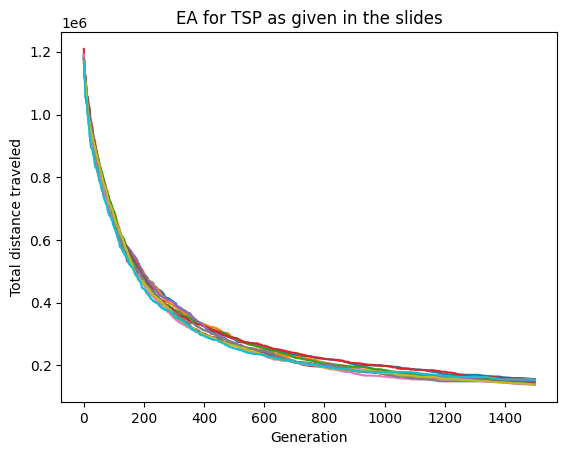

In [37]:
for x in distances:
    plt.plot(x)

plt.xlabel("Generation")
plt.ylabel("Total distance traveled")
plt.title("EA for TSP as given in the slides")
plt.show()

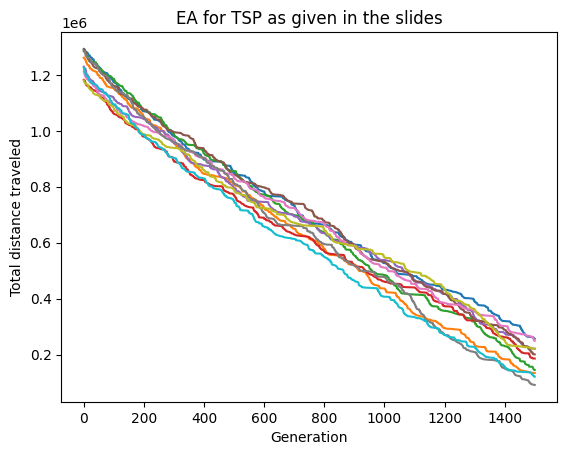

In [38]:
for x in distances_2opt_one_parent:
    plt.plot(x)

plt.xlabel("Generation")
plt.ylabel("Total distance traveled")
plt.title("EA for TSP as given in the slides")
plt.show()

In [39]:
for x in distances:
    print(x[-1])

156712.0
145268.0
147974.0
155628.0
149273.0
145533.0
137997.0
140553.0
139487.0
155555.0


In [40]:
for x in distances_2opt_one_parent:
    print(x[-1])

256349.0
133981.0
144948.0
185652.0
220971.0
200654.0
249087.0
91390.0
220712.0
120957.0
